In [96]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
#from LIM import utils as ut
from LIM.neural_networks import utils as ut
from LIM.neural_networks import LIM_class
#plt.style.use("./plotting.mplstyle")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
data = xr.open_dataset("C:/Users/felix/PycharmProjects/ML_Climate_Science_Research_Project/LIM/neural_networks/data/ts_Amon_CESM2_piControl_r1i1p1f1.nc")["ts"]
#data = xr.open_dataset("./data/zos_Amon_CESM2_piControl_r1i1p1f1.nc")["zos"]
#data_old = xr.open_dataset("./data/ssta_1950_2021.nc")["ssta"]
mask = xr.open_dataset("C:/Users/felix/PycharmProjects/ML_Climate_Science_Research_Project/LIM/neural_networks/data/sftlf_fx_CESM2_historical_r1i1p1f1.nc")["sftlf"]

#14400 orginial size
data = data[:, :, :]

data = ut.apply_mask(mask, data)
#print("Data : {} + shape {}".format(data, data.shape))

data_anomalies = ut.calculate_monthly_anomalies(data)
#print("Month mean : {} + shape : {}".format(data_anomalies, data_anomalies.shape))
data_cropped =ut.crop_xarray2(130, -70, data_anomalies)
data_cropped =ut.crop_xarray_lat(data_cropped)
#data_cropped =ut.crop_xarray(data_anomalies)


pca_10 = ut.SpatioTemporalPCA(data_cropped, n_components=20)
#pca_10 = ut.SpatioTemporalPCA(data_anomalies, n_components=20)
eof_10 = pca_10.eofs()
pc_10 = pca_10.principal_components()

<xarray.DataArray 'lon' (lon: 288)>
array([-180.  , -178.75, -177.5 , ...,  176.25,  177.5 ,  178.75])
Coordinates:
  * lon      (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8 288


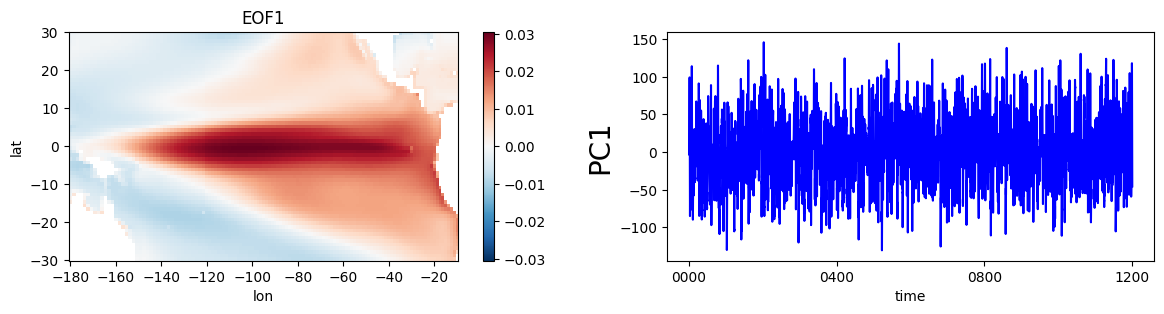

In [98]:
# Set the number of plots to 2
number_of_plots = 1

# Create the figure and axes objects
fig = plt.figure(figsize=(2 * 6, 3.5 * number_of_plots))

# Set titles and plot the contourf and plot for each EOF and PC
for i in range(number_of_plots):
    ax = fig.add_subplot(number_of_plots, 2, 2*i+1)
    eof_10[i].plot(ax=ax, cmap="RdBu_r")
    ax.set_title(f"EOF{i+1}")
    ax = fig.add_subplot(number_of_plots, 2, 2*i + 2)
    pc_10.isel(eof=i).plot(ax=ax, color="blue")
    ax.set_ylabel(f"PC{i+1}", fontsize=20)

# Add padding between subplots and adjust layout
fig.tight_layout(pad=2)
fig.savefig('./plots/svg/EOFS_timeseries_piControl__.svg', format='svg')
fig.savefig('./plots/png/EOFS_timeseries_piControl__.png', format='png')
plt.show()

In [99]:
# Create training and test data

data = pca_10.principal_components()
index_train = int(0.8 * len(data["time"]))
data_train = data[:, :index_train]
data_test = data[:, index_train:]

eps = 0.01

# Get input data
x_input = data_train.isel(time=0)
x_input = x_input.data

# original fit
tau = 1
model_org = LIM_class.LIM(tau)
model_org.fit(data_train.data, eps=eps)

eigenvalues_lst = []


for t in range(3):

    print("Iteration : {}".format(t))

        # Forecast mean using LIM model
    lim_integration, times_ = model_org.noise_integration(x_input, timesteps=10000, num_comp=len(pc_10), seed=t)
    lim_integration = lim_integration.T

    tau = 1
    model = LIM_class.LIM(tau)
    model.fit(lim_integration, eps=eps)

    logar_matr = model.logarithmic_matrix
    noise_matr = model.noise_covariance

    # Plotting eigenvalues of G
    eigenvalues, _, w = ut.matrix_decomposition(model.green_function)
    eigenvalues_lst.append(eigenvalues)


lim_integration, times_ = model_org.noise_integration(x_input, timesteps=20000, num_comp=len(pc_10), seed=99)
lim_integration = lim_integration.T

tau = 1
modelxx = LIM_class.LIM(tau)
modelxx.fit(lim_integration, eps=eps)

tau = 1
modelyy = LIM_class.LIM(tau)
modelyy.fit(lim_integration, eps=eps)


eigenvalues_org, _, w = ut.matrix_decomposition(model_org.green_function)
eigenvalues_xx, _, w = ut.matrix_decomposition(modelxx.green_function)
eigenvalues_yy, _, w = ut.matrix_decomposition(modelyy.green_function)

Covariance matrix has negative values!
Iteration : 0
t_delta is too big : 2.332479229737221 -> threshold: 2.3324893918769463!
t_delta: 2.332479229737221
Covariance matrix has negative values!
Iteration : 1
t_delta is too big : 2.332479229737221 -> threshold: 2.3324893918769463!
t_delta: 2.332479229737221
Covariance matrix has negative values!
Iteration : 2
t_delta is too big : 2.332479229737221 -> threshold: 2.3324893918769463!
t_delta: 2.332479229737221
Covariance matrix has negative values!
t_delta is too big : 2.332479229737221 -> threshold: 2.3324893918769463!
t_delta: 2.332479229737221
Covariance matrix has negative values!
Covariance matrix has negative values!


G_min : [-0.21424472, -0.5382921490378022]
G_max : [0.9795522, 0.9819753683298601]
L_min : [-0.38089556, -0.6648361250916494]
L_max : [0.27164325, 0.7346328080091812]
Q_min : [-7.025791, -11.36221154186283]
Q_max : [39.79104, 45.627552748666886]


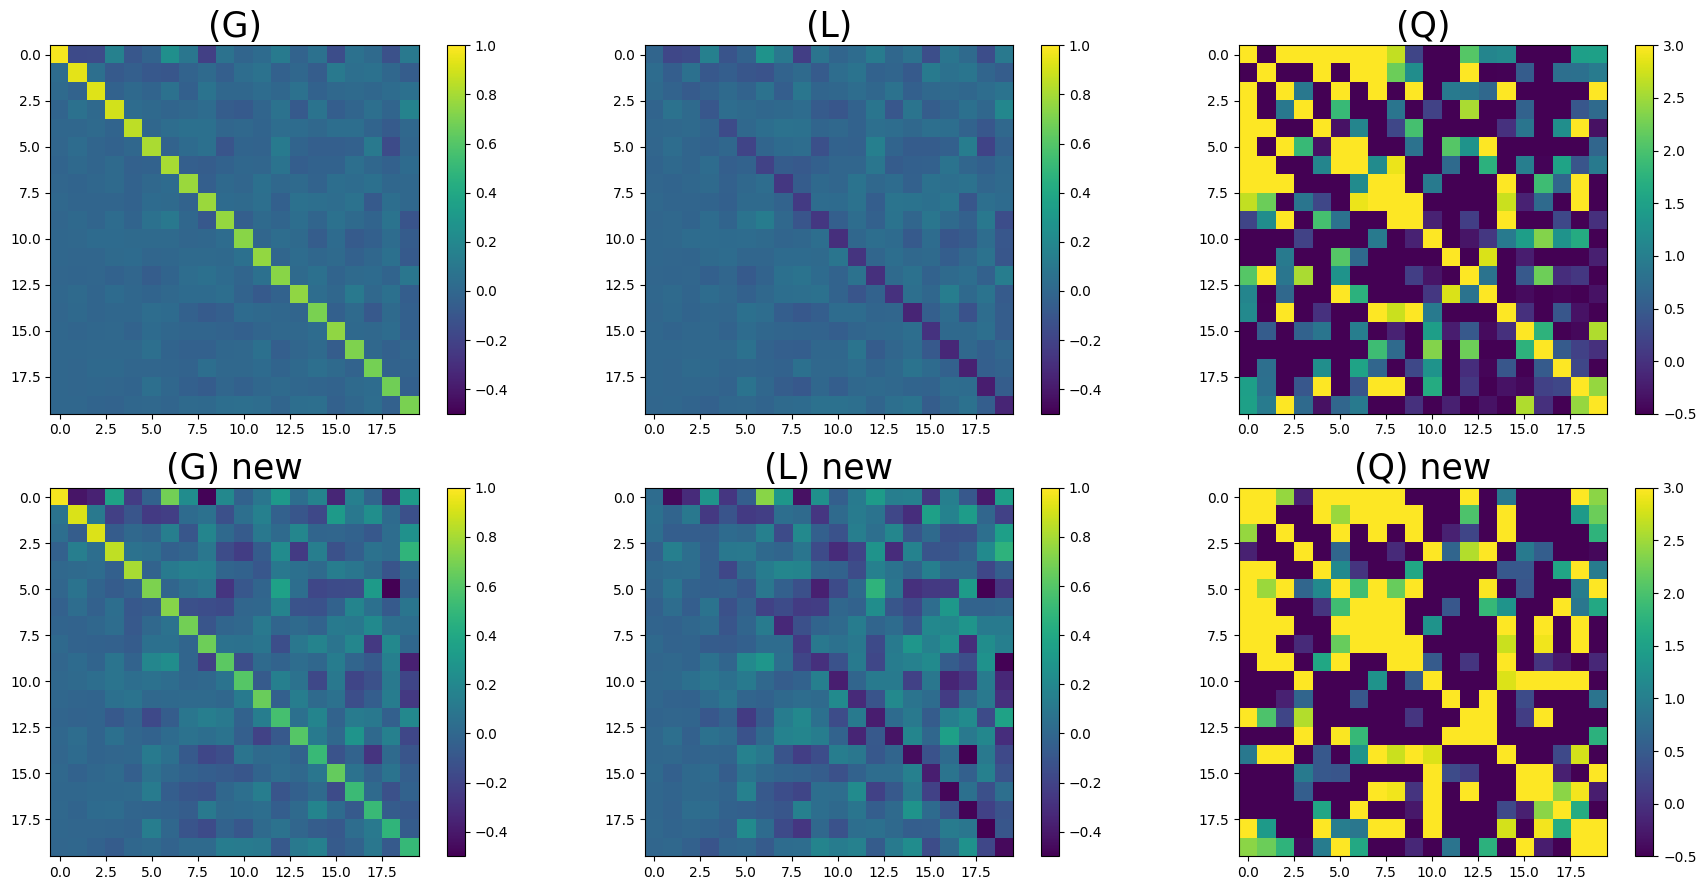

In [100]:
# Plot G, L, Q
fig, axs = plt.subplots(2, 3, figsize=(18, 9))

# Plot G
im1 = axs[0][0].imshow(model_org.green_function, vmin=-0.5, vmax=1)
#im1 = axs[0][0].imshow(model.green_function)
axs[0][0].set_title('(G)', fontsize=25)
fig.colorbar(im1, ax=axs[0][0])
im11 = axs[1][0].imshow(model.green_function, vmin=-0.5, vmax=1)
#im11 = axs[1][0].imshow(model2.green_function)
axs[1][0].set_title('(G) new', fontsize=25)
fig.colorbar(im11, ax=axs[1][0])

g_min = [np.min(model_org.green_function), np.min(model.green_function)]
g_max = [np.max(model_org.green_function), np.max(model.green_function)]
print("G_min : {}".format(g_min))
print("G_max : {}".format(g_max))

# Plot L
im2 = axs[0][1].imshow(np.real(model_org.logarithmic_matrix), vmin=-0.5, vmax=1)
#im2 = axs[0][1].imshow(np.real(model.logarithmic_matrix))
axs[0][1].set_title('(L)', fontsize=25)
fig.colorbar(im2, ax=axs[0][1])
im21 = axs[1][1].imshow(np.real(model.logarithmic_matrix), vmin=-0.5, vmax=1)
#im21 = axs[1][1].imshow(np.real(model2.logarithmic_matrix))
axs[1][1].set_title('(L) new', fontsize=25)
fig.colorbar(im21, ax=axs[1][1])

l_min = [np.min(np.real(model_org.logarithmic_matrix)), np.min(np.real(model.logarithmic_matrix))]
l_max = [np.max(np.real(model_org.logarithmic_matrix)), np.max(np.real(model.logarithmic_matrix))]
print("L_min : {}".format(l_min))
print("L_max : {}".format(l_max))


# Plot Q
im3 = axs[0][2].imshow(np.real(model_org.noise_covariance), vmin=-0.5, vmax=3)
#im3 = axs[0][2].imshow(np.real(model.noise_covariance))
axs[0][2].set_title('(Q)', fontsize=25)
fig.colorbar(im3, ax=axs[0][2])
im31 = axs[1][2].imshow(np.real(model.noise_covariance), vmin=-0.5, vmax=3)
#im31 = axs[1][2].imshow(np.real(model2.noise_covariance))
axs[1][2].set_title('(Q) new', fontsize=25)
fig.colorbar(im31, ax=axs[1][2])

q_min = [np.min(np.real(model_org.noise_covariance)), np.min(np.real(model.noise_covariance))]
q_max = [np.max(np.real(model_org.noise_covariance)), np.max(np.real(model.noise_covariance))]
print("Q_min : {}".format(q_min))
print("Q_max : {}".format(q_max))

plt.tight_layout()
fig.savefig('./plots/svg/G_Q_L_function_piControl__.svg', format='svg')
fig.savefig('./plots/png/G_Q_L_function_piControl__.png', format='png')
plt.show()

Covariance matrix has negative values!
t_delta is too big : 1.5581545056346937 -> threshold: 0.09840381509697135!
t_delta: 1.5581545056346937
t_delta is too big : 1.5581545056346937 -> threshold: 0.09840381509697135!
t_delta: 1.5581545056346937
t_delta is too big : 1.5581545056346937 -> threshold: 0.09840381509697135!
t_delta: 1.5581545056346937
t_delta is too big : 1.5581545056346937 -> threshold: 0.09840381509697135!
t_delta: 1.5581545056346937
t_delta is too big : 1.5581545056346937 -> threshold: 0.09840381509697135!
t_delta: 1.5581545056346937
t_delta is too big : 1.5581545056346937 -> threshold: 0.09840381509697135!
t_delta: 1.5581545056346937
t_delta is too big : 1.5581545056346937 -> threshold: 0.09840381509697135!
t_delta: 1.5581545056346937
t_delta is too big : 1.5581545056346937 -> threshold: 0.09840381509697135!
t_delta: 1.5581545056346937
t_delta is too big : 1.5581545056346937 -> threshold: 0.09840381509697135!
t_delta: 1.5581545056346937
t_delta is too big : 1.55815450563

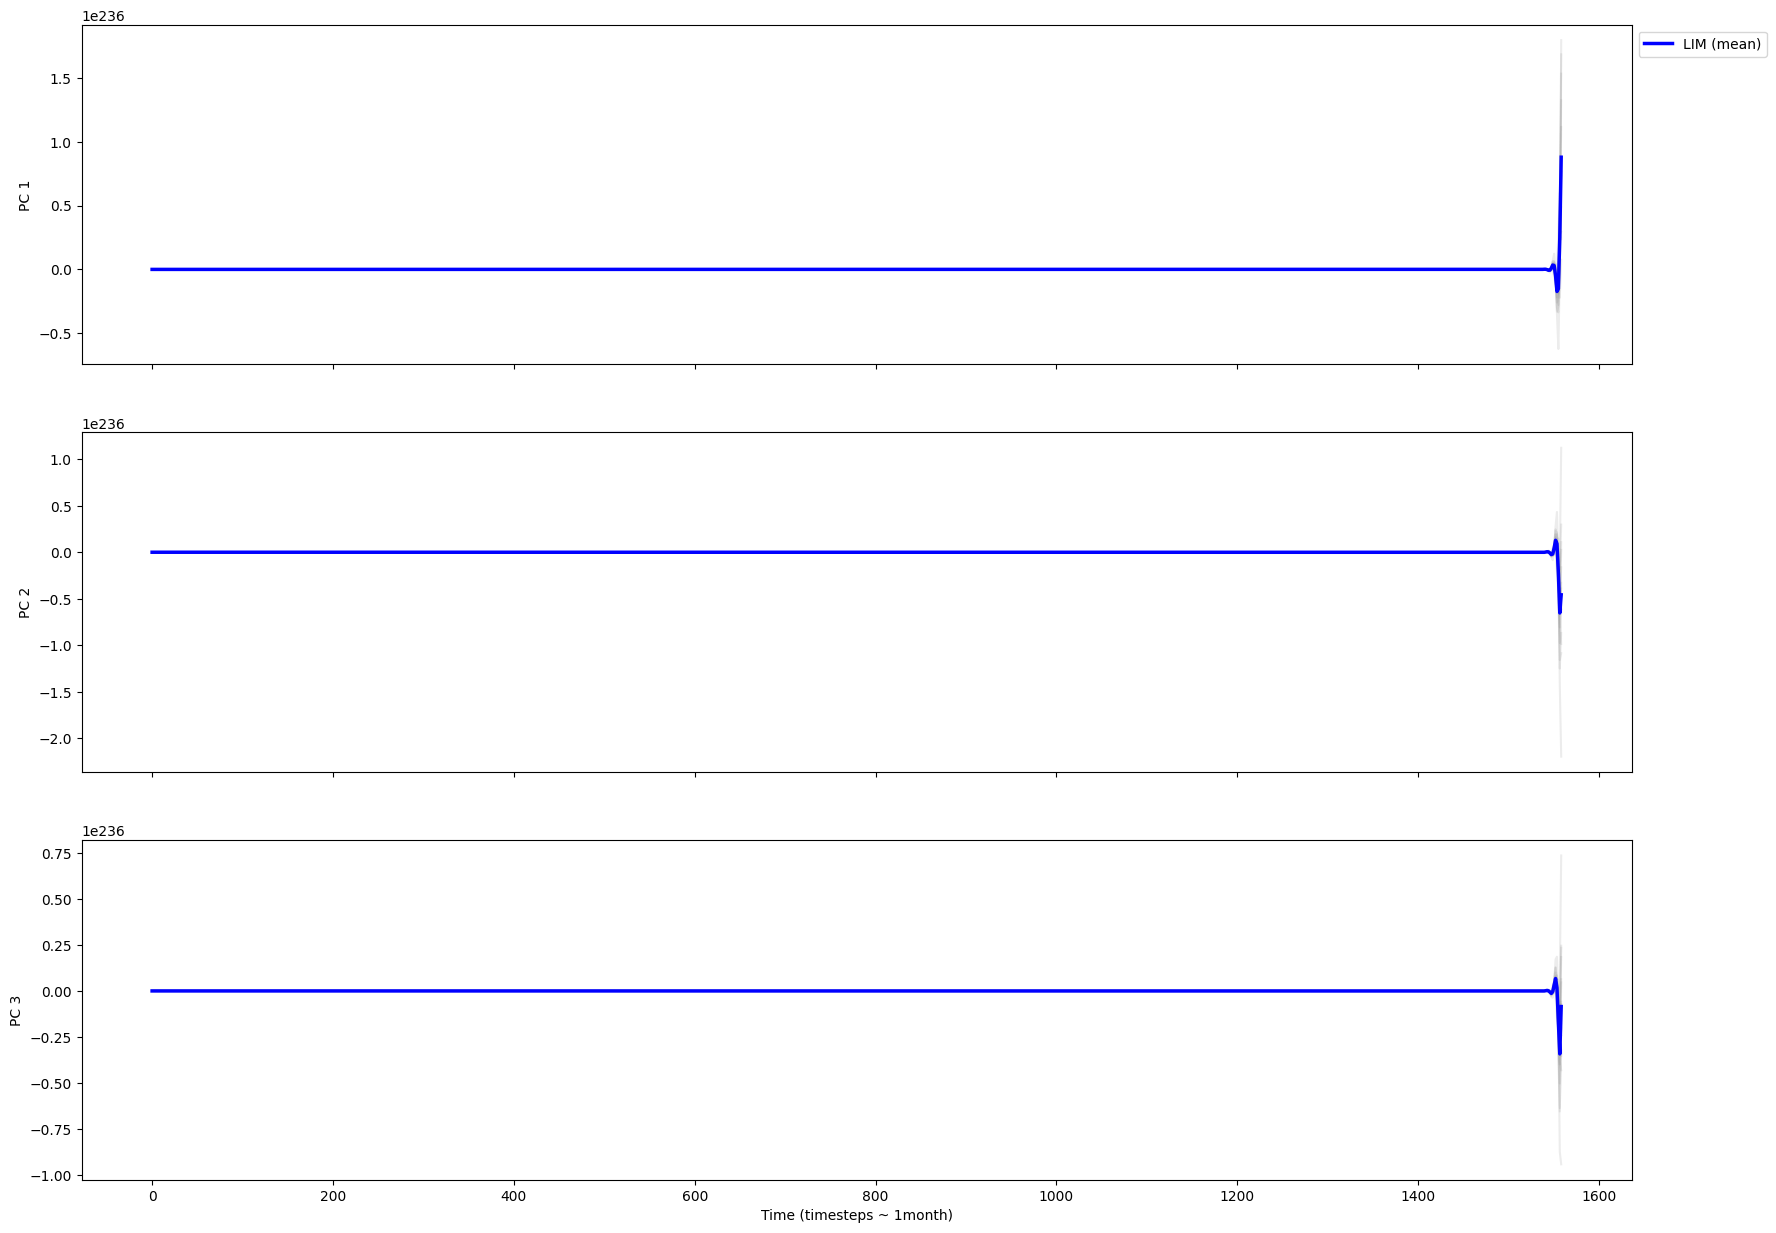

In [101]:
# Noise Integration

tau = 1
model = LIM_class.LIM(tau)
model.fit(lim_integration, eps=eps)

num_timeseries = 15

multiple_timeseries = []

for t in range(num_timeseries):
    # Forecast mean using LIM model
    lim_integration, times = model.noise_integration(x_input, timesteps=1000, num_comp=len(pc_10), seed=t)
    lim_integration = lim_integration.T
    multiple_timeseries.append(lim_integration)

mean_timeseries = np.mean(multiple_timeseries, axis=0)

# Plot time evolution of selected components
idx_components = [0, 1, 2]
fig, axs = plt.subplots(len(idx_components), figsize=(20, 15), sharex=True)

for i, component in enumerate(idx_components):

    for t in range(num_timeseries):
        #print("multiple_timeseries[t][component, :]: ", multiple_timeseries[t][component, :])
        axs[i].plot(times[:], multiple_timeseries[t][component, :], color='grey', alpha=0.15)

    # Plot forecasted data using LIM model
    axs[i].plot(times[:], mean_timeseries[component, :], color="blue", label=f'LIM (mean)', linewidth=2.5)

    # Set y-axis label
    axs[i].set_ylabel(f'PC {idx_components[i]+1}')

# Add legend
_ = axs[0].legend(bbox_to_anchor=(1, 1), loc="upper left")

# Set x-axis label for the last subplot
axs[-1].set_xlabel('Time (timesteps ~ 1month)')
fig.savefig('./plots/svg/LIM_integration_timeseries_piControl__.svg', format='svg')
fig.savefig('./plots/png/LIM_integration_timeseries_piControl__.png', format='png')
plt.show()

C:\Users\felix\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


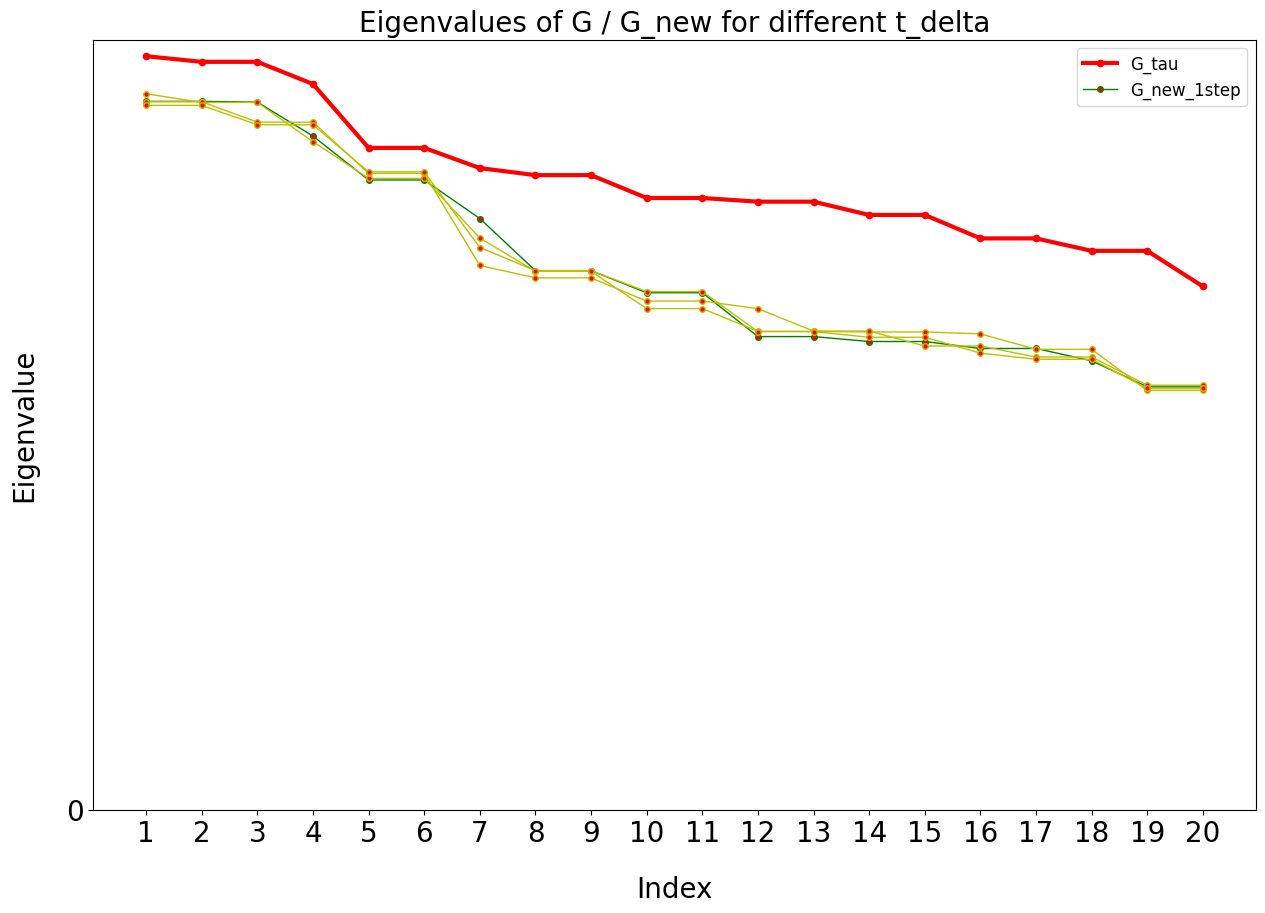

In [102]:
x = np.arange(1, len(eigenvalues_org) + 1)

# Plot the eigenvalues
plt.figure(figsize=(15,10))
plt.plot(x, eigenvalues_org, marker='o', linestyle='-', color='r', markersize=4.5, markerfacecolor='r', linewidth=3,
         label='G_tau')
plt.plot(x, eigenvalues_xx, marker='o', linestyle='-', color='g', markersize=4, markerfacecolor='r', linewidth=1,
         label='G_new_1step')
#plt.plot(x, eigenvalues_yy, marker='o', linestyle='-', color='orange', markersize=4, markerfacecolor='r', linewidth=1,
#          label='G_new_1step2')
# plt.plot(x, eigenvalues_zz, marker='o', linestyle='-', color='black', markersize=4, markerfacecolor='r', linewidth=1,
#          label='G_new_0.3delta')
# plt.plot(x, eigenvalues_cc, marker='o', linestyle='-', color='b', markersize=4, markerfacecolor='r', linewidth=1,
#          label='G_new_0.4delta')
# plt.plot(x, eigenvalues_lst[0], marker='o', linestyle='-', color='y', markersize=4, markerfacecolor='r', linewidth=1, label='G_new_0.5delta')

for y in range(len(eigenvalues_lst)):
    plt.plot(x, eigenvalues_lst[y], marker='o', linestyle='-', color='y', markersize=4, markerfacecolor='r', linewidth=1)






# Set the labels and title
plt.xlabel('Index', fontsize=20, labelpad=20)
plt.ylabel('Eigenvalue', fontsize=20, labelpad=20)
plt.title('Eigenvalues of G / G_new for different t_delta', fontsize=20)

# Set the x-axis tick labels
plt.xticks(x, fontsize=20)
plt.yticks(range(0,1), fontsize=20)
plt.legend(loc="upper right", fontsize=12)

# Display the plot
plt.savefig('./plots/svg/eigenvalues_G_combined_piControl_step__.svg', format='svg')
plt.savefig('./plots/png/eigenvalues_G_combined_piControl_step__.png', format='png')
plt.show()